# Imports

In [58]:
import requests
import os
import shutil
import zipfile
import tensorflow as tf
import os
import numpy as np
import librosa
import glob
import datetime


# Download dataset

In [59]:
def download_ds(url, download_path, target_path):
    response = requests.get(url, stream=True)

    if response.status_code != 200:
        print(f"Failed to download file. Status code: {response.status_code}")
        return
    
    with open(download_path, 'wb') as file:
        shutil.copyfileobj(response.raw, file)
    print("Download completed successfully.")
        
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(target_path)
    print("Extraction completed successfully.")
        
    os.remove(download_path)

## Free Music Archive (FMA)

In [60]:
train_ds_url = 'https://os.unil.cloud.switch.ch/fma/fma_small.zip'

download_path = 'train_ds.zip'

train_ds_path = 'train_ds'

if not os.path.exists(train_ds_path):
    download_ds(train_ds_url, download_path, train_ds_path)

# Constants

In [61]:
BATCH_SIZE = 4
TRAIN_DS_SIZE = 500
SAMPLE_RATE = 8000
MAX_AUDIO_LENGTH = SAMPLE_RATE * 1
EPOCHS = 5

# Preprocess dataset

In [62]:
def load_mp3(file_path):
    file_path = file_path.numpy().decode('utf-8')
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
    return audio_tensor

def load_mp3_wrapper(file_path):
    audio = tf.py_function(load_mp3, [file_path], tf.float32)
    return audio, audio

def pad_audio(audio, label):
    audio_length = tf.shape(audio)[0]
    
    if audio_length < MAX_AUDIO_LENGTH:
        padding = MAX_AUDIO_LENGTH - audio_length
        audio = tf.pad(audio, [[0, padding]], constant_values=0)
        label = tf.pad(label, [[0, padding]], constant_values=0)
    else:
        audio = tf.slice(audio, [0], [MAX_AUDIO_LENGTH])
        label = tf.slice(label, [0], [MAX_AUDIO_LENGTH])
    
    return audio, label

def get_all_mp3_paths(root_dir):
    mp3_paths = glob.glob(os.path.join(root_dir, '**/*.mp3'), recursive=True)
    return mp3_paths

In [63]:
audio_file_paths = get_all_mp3_paths(train_ds_path)
sampled_audio_files = audio_file_paths[:TRAIN_DS_SIZE]
train_ds = tf.data.Dataset.from_tensor_slices(sampled_audio_files)

train_ds = train_ds.map(lambda x: load_mp3_wrapper(x))

train_ds = train_ds.map(pad_audio)

In [64]:
for data, label in train_ds.take(1):
    print(f"Data shape: {data.shape}")
    print(f"Label shape: {label.shape}")
    assert data.shape == (MAX_AUDIO_LENGTH,)
    assert label.shape == (MAX_AUDIO_LENGTH,)

Data shape: (8000,)
Label shape: (8000,)


In [65]:
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Define the model

In [66]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class Autoencoder(Model):
    def __init__(self, input_shape, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv1D(64, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(pool_size=2, padding='same'),
            layers.Conv1D(32, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(pool_size=2, padding='same'),
            layers.Conv1D(16, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(pool_size=2, padding='same'),
            layers.Conv1D(8, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(pool_size=2, padding='same'),
            layers.Conv1D(4, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(pool_size=2, padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense((input_shape[0] // 32) * latent_dim, activation='relu'),
            layers.Reshape(((input_shape[0] // 32), latent_dim)),
            layers.UpSampling1D(size=2),
            layers.Conv1D(4, 3, activation='relu', padding='same'),
            layers.UpSampling1D(size=2),
            layers.Conv1D(8, 3, activation='relu', padding='same'),
            layers.UpSampling1D(size=2),
            layers.Conv1D(16, 3, activation='relu', padding='same'),
            layers.UpSampling1D(size=2),
            layers.Conv1D(32, 3, activation='relu', padding='same'),
            layers.UpSampling1D(size=2),
            layers.Conv1D(64, 3, activation='relu', padding='same'),
            layers.Conv1D(1, 3, activation='tanh', padding='same')
        ])
    
    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed


In [67]:
target_compression_ratio = 1000
latent_dim = MAX_AUDIO_LENGTH / target_compression_ratio
print(f"Latent dimension: {latent_dim}")
latent_dim = int(latent_dim)
print(f"Latent dimension: {latent_dim}")

Latent dimension: 8.0
Latent dimension: 8


In [68]:
# Usage example
latent_dim = 1024  # You can try larger values here
learning_rate = 0.001

In [69]:
autoencoder = Autoencoder((MAX_AUDIO_LENGTH, 1), latent_dim)
def spectral_loss(y_true, y_pred):
    # Compute the spectrograms of the true and predicted signals
    spectrogram_true = tf.signal.stft(y_true, frame_length=256, frame_step=64)
    spectrogram_pred = tf.signal.stft(y_pred, frame_length=256, frame_step=64)
    
    # Compute the magnitude of the spectrograms
    magnitude_true = tf.abs(spectrogram_true)
    magnitude_pred = tf.abs(spectrogram_pred)
    
    # Compute the spectral loss (MAE between magnitudes)
    return tf.reduce_mean(tf.abs(magnitude_true - magnitude_pred))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=spectral_loss)
autoencoder.fit(train_ds, epochs=EPOCHS)

Epoch 1/5
125/125 [==============================] - 481s 2s/step - loss: 0.5846
Epoch 2/5
125/125 [==============================] - 310s 2s/step - loss: 0.5545
Epoch 3/5
125/125 [==============================] - 340s 3s/step - loss: 0.5486
Epoch 4/5
125/125 [==============================] - 324s 3s/step - loss: 0.5420
Epoch 5/5
125/125 [==============================] - 305s 2s/step - loss: 0.5361


In [27]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = f'models/audio_autoencoder_{current_time}'
autoencoder.save(model_save_path, save_format='tf')

INFO:tensorflow:Assets written to: models/audio_autoencoder_20240522_034441\assets


INFO:tensorflow:Assets written to: models/audio_autoencoder_20240522_034441\assets


In [10]:
autoencoder = tf.keras.models.load_model('audio_autoencoder')

In [70]:
TEST_DS_SIZE = BATCH_SIZE * 1
test_ds = tf.data.Dataset.from_tensor_slices(audio_file_paths[TRAIN_DS_SIZE:TRAIN_DS_SIZE + TEST_DS_SIZE])
test_ds = test_ds.map(lambda x: load_mp3_wrapper(x))
test_ds = test_ds.map(pad_audio)

In [71]:
for data, label in test_ds.take(1):
    print(f"Data shape: {data.shape}")
    print(f"Label shape: {label.shape}")
    assert data.shape == (MAX_AUDIO_LENGTH,)
    assert label.shape == (MAX_AUDIO_LENGTH,)

Data shape: (8000,)
Label shape: (8000,)


In [72]:
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [73]:
def compute_reconstruction_error(autoencoder, test_ds):
    mse = tf.keras.losses.MeanSquaredError()
    total_loss = 0
    num_batches = 0
    
    for data, _ in test_ds:
        reconstructed = autoencoder(data)
        loss = mse(data, reconstructed).numpy()
        total_loss += loss
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    print(f"Average Reconstruction Error (MSE) on Test Set: {avg_loss}")
    return avg_loss

import matplotlib.pyplot as plt
def plot_original_vs_reconstructed(autoencoder, test_ds):
    for data, _ in test_ds.take(1):
        reconstructed = autoencoder(data)
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))
        
        axes[0].plot(data[0].numpy())
        axes[0].set_title('Original Audio')
        
        axes[1].plot(reconstructed[0].numpy())
        axes[1].set_title('Reconstructed Audio')
        
        plt.show()
        break
    
import IPython.display as ipd

def play_audio_samples(autoencoder, test_ds, num_samples=5):
    for data, _ in test_ds.take(1):
        reconstructed = autoencoder(data)
        reconstructed = tf.squeeze(reconstructed, axis=-1)
        
        for audio, reconstructed_audio in zip(data[:num_samples], reconstructed[:num_samples]):
            print("Original Audio:")
            ipd.display(ipd.Audio(audio.numpy(), rate=44100))
            
            print("Reconstructed Audio:")
            ipd.display(ipd.Audio(reconstructed_audio.numpy(), rate=44100))


In [74]:
compute_reconstruction_error(autoencoder, test_ds)

Average Reconstruction Error (MSE) on Test Set: 0.009370842948555946


0.009370842948555946

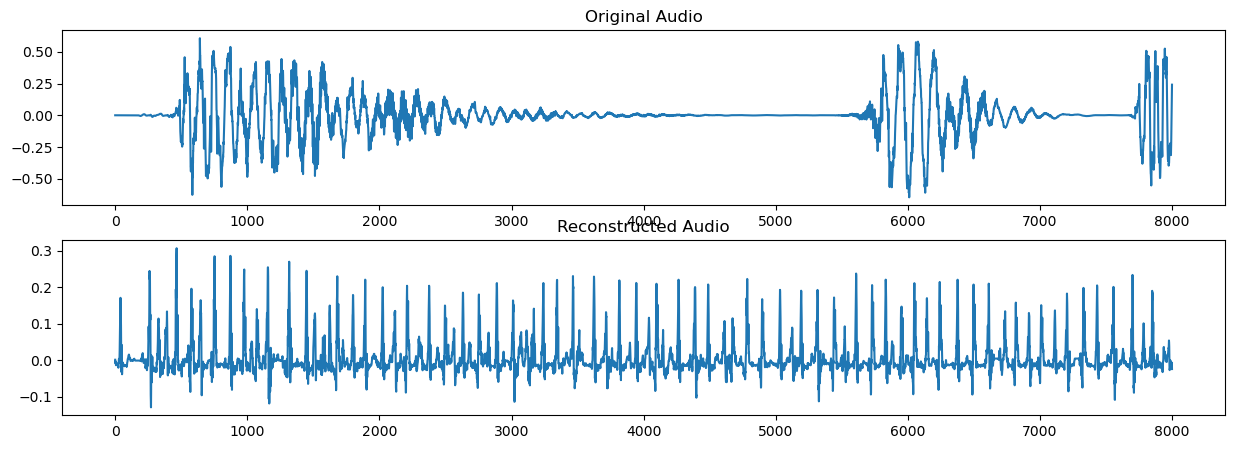

In [75]:
plot_original_vs_reconstructed(autoencoder, test_ds)

In [76]:
play_audio_samples(autoencoder, test_ds)

Original Audio:


Reconstructed Audio:


Original Audio:


Reconstructed Audio:


Original Audio:


Reconstructed Audio:


Original Audio:


Reconstructed Audio:
